<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4560 entries, 0 to 4559
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        4560 non-null   object
 1   label       4560 non-null   int64 
 2   label_name  4560 non-null   object
dtypes: int64(1), object(2)
memory usage: 107.0+ KB


,text,label,label_name
0,The Organization of the Petroleum Exporting Co...,0,Business
1,American business tycoon Malcolm Glazer has in...,2,Sports
2,NEW YORK (Reuters) - International Business Ma...,1,SciTech
3,"Unilever, the world #39;s largest maker of foo...",0,Business
4,Australia #39;s Nathan Baggaley was over the m...,2,Sports


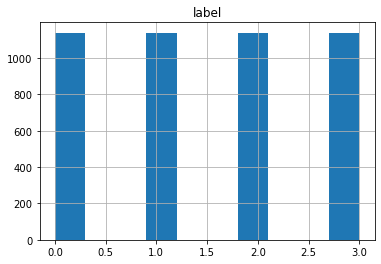

In [1]:
import pandas as pd

df_train = pd.read_json("../data/news_train.json", orient='records')
df_train.info()
df_train.hist()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        1520 non-null   object
 1   label       1520 non-null   int64 
 2   label_name  1520 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.8+ KB


,text,label,label_name
0,While rivals scramble to catch up on the deskt...,1,SciTech
1,AP - UCLA soccer coach Jillian Ellis was happy...,2,Sports
2,PCI Express allows Nvidia to tap into system m...,1,SciTech
3,AP - The Federal Election Commission on Thursd...,3,World
4,City officials hope there are people willing t...,1,SciTech


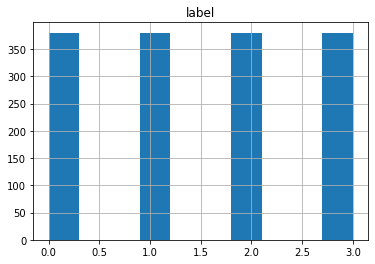

In [2]:
df_test = pd.read_json("../data/news_test.json", orient='records')
df_test.info()
df_test.hist()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        1520 non-null   object
 1   label       1520 non-null   int64 
 2   label_name  1520 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.8+ KB


,text,label,label_name
0,The first hearing in the re-trial of former le...,3,World
1,Intel #39;s board has given the go ahead for t...,0,Business
2,Stocks closed higher on Wall Street as investo...,0,Business
3,Even with a boost from higher oil prices and g...,0,Business
4,Vornado Realty Trust said on Friday it has acq...,0,Business


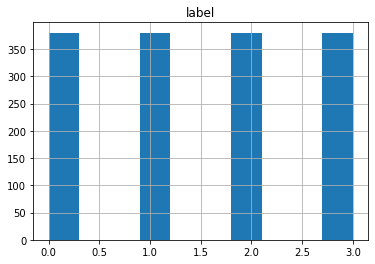

In [3]:
df_val = pd.read_json("../data/news_val.json", orient='records')
df_val.info()
df_val.hist()
df_val.head()

In [4]:
import numpy as np
from tokenizers import BertWordPieceTokenizer

tokenizer = BertWordPieceTokenizer("../data/bert-base-uncased-vocab.txt",
                                   lowercase=True)

def bert_tokenizer(data):
    result = []
    for item in data:
        result.append(tokenizer.encode(item).ids)
    
    return np.array(result)

In [5]:
import tensorflow as tf

maxlen = 128

X_train = list(df_train["text"].values)
X_train = bert_tokenizer(X_train)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
y_train = df_train["label"].values

X_val = list(df_val["text"].values)
X_val = bert_tokenizer(X_val)
y_val = df_val["label"].values
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, maxlen=maxlen)

X_test = list(df_test["text"].values)
X_test = bert_tokenizer(X_test)
y_test = df_test["label"].values
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)

In [6]:
import tensorflow as tf

max_features = 30523  # vocab size

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, 8, input_length=maxlen),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(units=4, activation='softmax')
]) 

model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 8)            244184    
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                32800     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 277,116
Trainable params: 277,116
Non-trainable params: 0
_________________________________________________________________


In [7]:
h = model.fit(X_train, 
              y_train,
              epochs=10,
              batch_size=32,
              validation_data=(X_val, y_val))

Epoch 1/10
143/143 [==============================] - 1s 8ms/step - loss: 1.3515 - accuracy: 0.3395 - val_loss: 1.2189 - val_accuracy: 0.5099
Epoch 2/10
143/143 [==============================] - 1s 5ms/step - loss: 0.7772 - accuracy: 0.7592 - val_loss: 0.6537 - val_accuracy: 0.7645
Epoch 3/10
143/143 [==============================] - 1s 5ms/step - loss: 0.2712 - accuracy: 0.9272 - val_loss: 0.5039 - val_accuracy: 0.8237
Epoch 4/10
143/143 [==============================] - 1s 5ms/step - loss: 0.0941 - accuracy: 0.9838 - val_loss: 0.4940 - val_accuracy: 0.8151
Epoch 5/10
143/143 [==============================] - 1s 6ms/step - loss: 0.0335 - accuracy: 0.9982 - val_loss: 0.5008 - val_accuracy: 0.8171
Epoch 6/10
143/143 [==============================] - 1s 5ms/step - loss: 0.0155 - accuracy: 0.9998 - val_loss: 0.5101 - val_accuracy: 0.8204
Epoch 7/10
143/143 [==============================] - 1s 6ms/step - loss: 0.0088 - accuracy: 0.9998 - val_loss: 0.5211 - val_accuracy: 0.8211
Epoch 

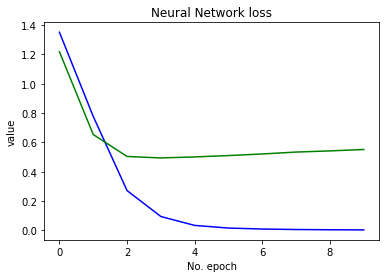

In [8]:
import matplotlib.pyplot as plt

plt.plot(h.history['loss'], label='(training data)',color='blue')
plt.plot(h.history['val_loss'], label='(val data)',color='green')
plt.title('Neural Network loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

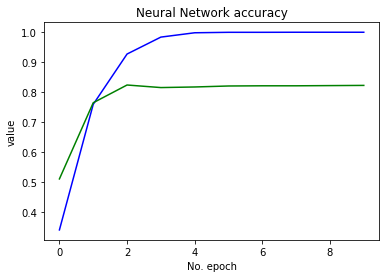

In [9]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'], label='(training data)',color='blue')
plt.plot(h.history['val_accuracy'], label='(val data)',color='green')
plt.title('Neural Network accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

In [10]:
results = model.evaluate(X_test, y_test, batch_size=32)
print("test loss, test acc:", results)

48/48 [==============================] - 0s 3ms/step - loss: 0.5609 - accuracy: 0.8145
test loss, test acc: [0.5609468221664429, 0.8144736886024475]


In [11]:
df_test_raw = pd.read_json("../data/news_test.json", orient="records")

In [12]:
predictions = np.round(model.predict(X_test[:100]))
for i in range(len(predictions)):
    print(df_test_raw["text"].values[i][:100],"...")
    print("Pred: ", predictions[i], "Real: ", y_test[i])

While rivals scramble to catch up on the desktop, Google plans to digitize famous libraries. Its off ...
Pred:  [0. 1. 0. 0.] Real:  1
AP - UCLA soccer coach Jillian Ellis was happy to beat her best friend, Princeton counterpart Julie  ...
Pred:  [0. 0. 1. 0.] Real:  2
PCI Express allows Nvidia to tap into system memory to save expensive on-board graphics memory and a ...
Pred:  [0. 1. 0. 0.] Real:  1
AP - The Federal Election Commission on Thursday elected a new chairman and vice chairman, choosing  ...
Pred:  [0. 0. 0. 1.] Real:  3
City officials hope there are people willing to pay plenty of money to own a vintage Playboy Bunny c ...
Pred:  [0. 0. 0. 1.] Real:  1
KIEV (Reuters) - Ukrainian Prime Minister Viktor Yanukovich  said on Saturday he would stand against ...
Pred:  [0. 0. 0. 1.] Real:  3
AFP - French auto giant Renault SA said it will invest some 570 million dollars in South Korea over  ...
Pred:  [1. 0. 0. 0.] Real:  3
Buffalo Bills offensive coordinator Tom Clements has em